
# CycleGAN Experiment 2: Full Training with Enhanced Logging

This notebook replicates Experiment 1 but with full training (no quick test), enhanced WandB logging (test & train images), and modified checkpoint naming.


In [1]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition'
# Use your actual token here if the repo is private, or just the https link if public
# Since I don't have your token, I'll assume you want to clone via HTTPS or SSH
# REPLACE THIS URL with your actual repo URL
REPO_URL = "https://github.com/konstantine25b/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition.git"

# 1. Remove existing repository if it exists
if os.path.exists(REPO_PATH):
    print(f"Removing existing repository at {REPO_PATH}...")
    try:
        shutil.rmtree(REPO_PATH)
        print("✅ Removed old repository.")
    except Exception as e:
        print(f"❌ Error removing repository: {e}")

# 2. Clone fresh copy
print(f"Cloning fresh repository from {REPO_URL}...")
# We cd to the parent directory first
os.chdir('/content/drive/MyDrive')
!git clone {REPO_URL}

# 3. Enter the repository
if os.path.exists(REPO_PATH):
    os.chdir(REPO_PATH)
    print(f"✅ Successfully cloned and entered: {os.getcwd()}")
    !ls
else:
    print("❌ Clone failed. Please check your URL or permissions.")

Cloning fresh repository from https://github.com/konstantine25b/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition.git...
Cloning into 'Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition'...
remote: Enumerating objects: 7448, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 7448 (delta 2), reused 9 (delta 2), pack-reused 7438 (from 2)
Receiving objects: 100% (7448/7448), 489.21 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (7381/7381), done.
✅ Successfully cloned and entered: /content/drive/MyDrive/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition
data  notebooks  README.md  requirements.txt  src


In [3]:

# GitHub Configuration & Setup
import os

# --- CONFIGURATION ---
# Please double-check this path matches where you cloned the repo in your Drive
REPO_PATH = '/content/drive/MyDrive/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition'

try:
    # 1. Change to the repository directory
    if os.path.exists(REPO_PATH):
        %cd "$REPO_PATH"
        print(f"Changed directory to {REPO_PATH}")
    else:
        print(f"Warning: Could not find repository at {REPO_PATH}.")
        print("Please update 'REPO_PATH' variable to point to your cloned repository folder.")
        # Attempting to list MyDrive to help user find the folder
        print("Listing folders in MyDrive to help identify path:")
        !ls -d /content/drive/MyDrive/*/

    # 2. Configure Git
    user_name = "konstantine25b"
    mail = "konstantine25b@gmail.com"

    # --- IMPORTANT: PASTE YOUR TOKEN BELOW ---
    my_token = "YOUR_TOKEN_HERE"

    if my_token == "YOUR_TOKEN_HERE":
        print("⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.")

    repo_url = f"https://{my_token}@github.com/konstantine25b/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition.git"

    !git config --global user.name "{user_name}"
    !git config --global user.email "{mail}"

    # 3. Set Remote URL
    if os.path.isdir(".git") and my_token != "YOUR_TOKEN_HERE":
        !git remote set-url origin "{repo_url}"
        print("Git configured successfully for pushing.")
    else:
        print("Skipping remote setup (either not a git repo or token not set).")

except Exception as e:
    print(f"Error setting up GitHub: {e}")


/content
Changed directory to /content/drive/MyDrive/Kaggle_GANS_I-m-Something-of-a-Painter-Myself_Competition
⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.
Skipping remote setup (either not a git repo or token not set).


In [ ]:

!pip install "wandb[workspaces]" -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.3 MB/s eta 0:00:00


In [4]:

# Install requirements
!pip install -r requirements.txt
!pip install wandb -q


In [5]:

import wandb
import sys
import os
import glob
import re
import random
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# Add src to path so we can import modules
sys.path.append('src')

from models.generator.resnet_gan import ResNetGenerator
from models.discriminator.patch_gan import PatchDiscriminator
from utils.dataset import ImageDataset, get_transforms
from utils.helpers import ReplayBuffer, weights_init_normal


In [ ]:

# Login to WandB
wandb.login()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True


## 1. Data Loading and Splitting


In [6]:

# Configuration
MONET_PATH = 'data/monet_jpg'
PHOTO_PATH = 'data/photo_jpg'
# Keeping the same directory but we will modify filenames
CHECKPOINT_DIR = '/content/drive/MyDrive/MonetGAN_Checkpoints_Exp1'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BATCH_SIZE = 4
N_EPOCHS = 30
LR = 0.0002
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- FULL TRAINING ---
QUICK_TEST = False




Using device: cuda



# WandB Report Information


In [7]:
# Get file paths
monet_files = sorted(glob.glob(os.path.join(MONET_PATH, "*.*")))
photo_files = sorted(glob.glob(os.path.join(PHOTO_PATH, "*.*")))

# Force full dataset (QUICK_TEST is False)
print(f"Total Monet images: {len(monet_files)}")
print(f"Total Photo images: {len(photo_files)}")

# Shuffle files
random.seed(42)
random.shuffle(monet_files)
random.shuffle(photo_files)

def split_data(files, is_monet=False):
    # Dynamic split size:
    # Use 1 for Monet (to keep max training data)
    # Use 50 for Photos (to have better validation visualization)
    n_val = 1 if is_monet else 50

    if is_monet:
        val = files[:n_val]
        train = files[n_val:]
        test = []
    else:
        # Full training split
        n_test = 30
        val = files[:n_val]
        test = files[n_val:n_val+n_test]
        train = files[n_val+n_test:]

    return train, val, test

monet_train, monet_val, monet_test = split_data(monet_files, is_monet=True)
photo_train, photo_val, photo_test = split_data(photo_files, is_monet=False)

print(f"Monet Splits - Train: {len(monet_train)}, Val: {len(monet_val)}, Test: {len(monet_test)}")
print(f"Photo Splits - Train: {len(photo_train)}, Val: {len(photo_val)}, Test: {len(photo_test)}")

Total Monet images: 300
Total Photo images: 7038
Monet Splits - Train: 299, Val: 1, Test: 0
Photo Splits - Train: 6958, Val: 50, Test: 30


In [8]:

# Create Datasets and DataLoaders
transforms_ = get_transforms()

train_dataset = ImageDataset(monet_train, photo_train, transform=transforms_)
val_dataset = ImageDataset(monet_val, photo_val, transform=transforms_)
test_dataset = ImageDataset(monet_val, photo_test, transform=transforms_)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


## 2. Visualize Data

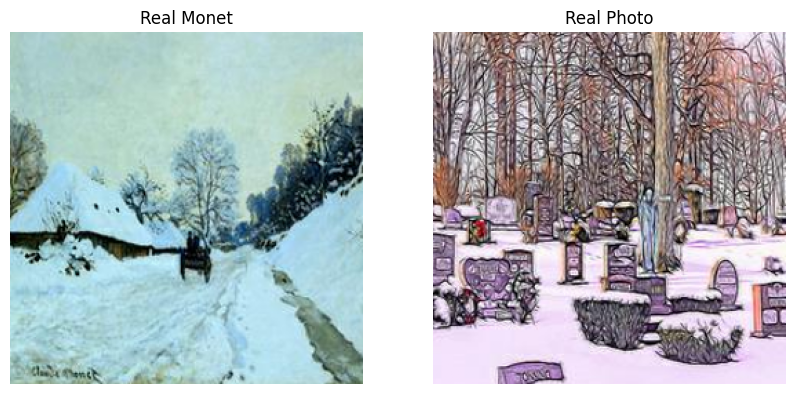

In [9]:

def denormalize(tensor):
    return tensor * 0.5 + 0.5

batch = next(iter(train_loader))
real_monet = batch['monet']
real_photo = batch['photo']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(denormalize(real_monet[0]).permute(1, 2, 0).cpu().numpy())
plt.title("Real Monet")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denormalize(real_photo[0]).permute(1, 2, 0).cpu().numpy())
plt.title("Real Photo")
plt.axis('off')
plt.show()


## 3. Model Initialization & Resume Logic

In [10]:

G_Monet = ResNetGenerator().to(DEVICE)
G_Photo = ResNetGenerator().to(DEVICE)
D_Monet = PatchDiscriminator().to(DEVICE)
D_Photo = PatchDiscriminator().to(DEVICE)

G_Monet.apply(weights_init_normal)
G_Photo.apply(weights_init_normal)
D_Monet.apply(weights_init_normal)
D_Photo.apply(weights_init_normal)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_Monet.parameters(), G_Photo.parameters()),
    lr=LR, betas=(0.5, 0.999)
)
optimizer_D_Monet = torch.optim.Adam(D_Monet.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D_Photo = torch.optim.Adam(D_Photo.parameters(), lr=LR, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / float(50 - 25 + 1)
)
lr_scheduler_D_Monet = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_Monet, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / float(50 - 25 + 1)
)
lr_scheduler_D_Photo = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_Photo, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 25) / float(50 - 25 + 1)
)


In [11]:

# --- RESUME LOGIC (Modified for _2 suffix) ---
def find_latest_checkpoint(checkpoint_dir):
    # Look for files ending with _2.pth
    files = glob.glob(os.path.join(checkpoint_dir, "G_Monet_epoch_*_2.pth"))
    if not files:
        return 0
    # Extract epoch number properly considering the _2 suffix
    # Format is G_Monet_epoch_{epoch}_2.pth
    epochs = [int(re.search(r'epoch_(\d+)_2.pth', f).group(1)) for f in files]
    return max(epochs)

start_epoch = find_latest_checkpoint(CHECKPOINT_DIR)

if start_epoch > 0:
    print(f"Found checkpoint! Resuming from epoch {start_epoch}...")
    # Load with the _2 suffix
    G_Monet.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f'G_Monet_epoch_{start_epoch}_2.pth'), map_location=DEVICE))
    G_Photo.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f'G_Photo_epoch_{start_epoch}_2.pth'), map_location=DEVICE))
    D_Monet.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f'D_Monet_epoch_{start_epoch}_2.pth'), map_location=DEVICE))
    D_Photo.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f'D_Photo_epoch_{start_epoch}_2.pth'), map_location=DEVICE))

    for _ in range(start_epoch):
        lr_scheduler_G.step()
        lr_scheduler_D_Monet.step()
        lr_scheduler_D_Photo.step()
else:
    print("No checkpoint found. Starting from scratch.")


Found checkpoint! Resuming from epoch 29...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


## 4. Training Loop with Visualizations

Starting training from epoch 29 to 30...


Epoch 30/30:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 finished. Avg Generator Loss: 1.7985


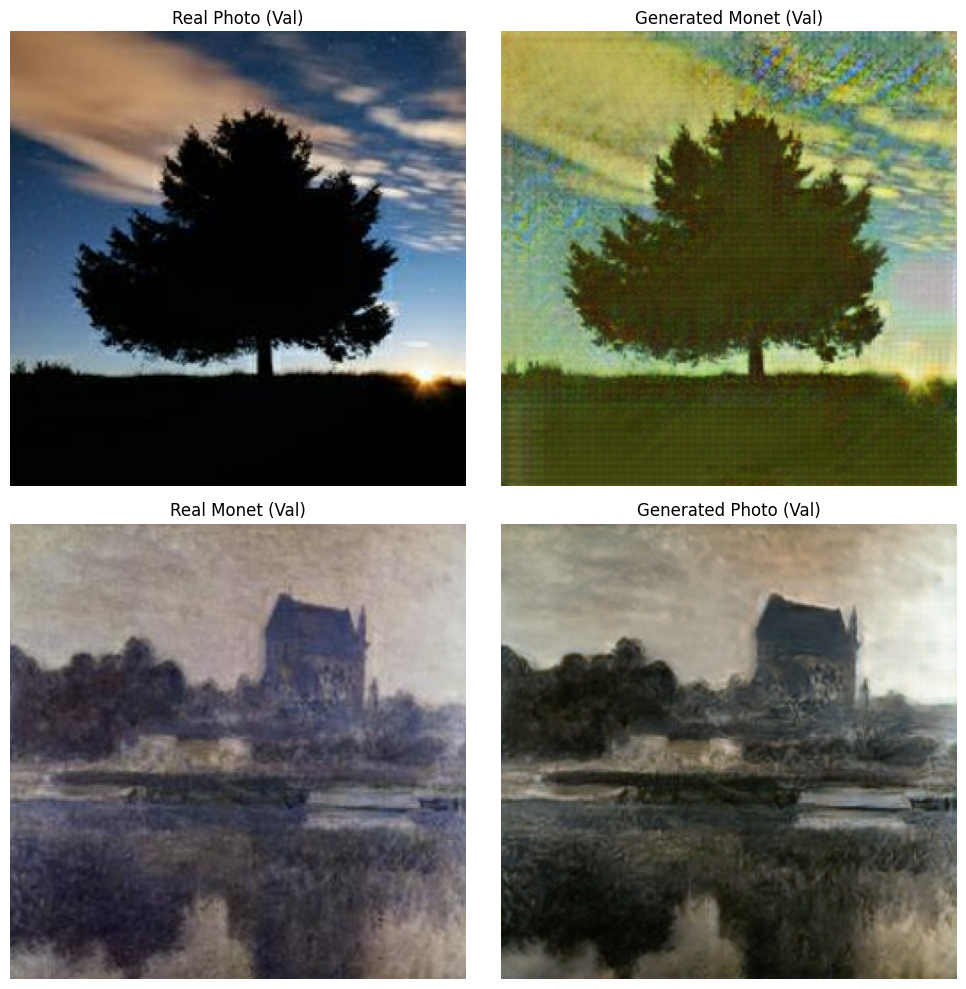

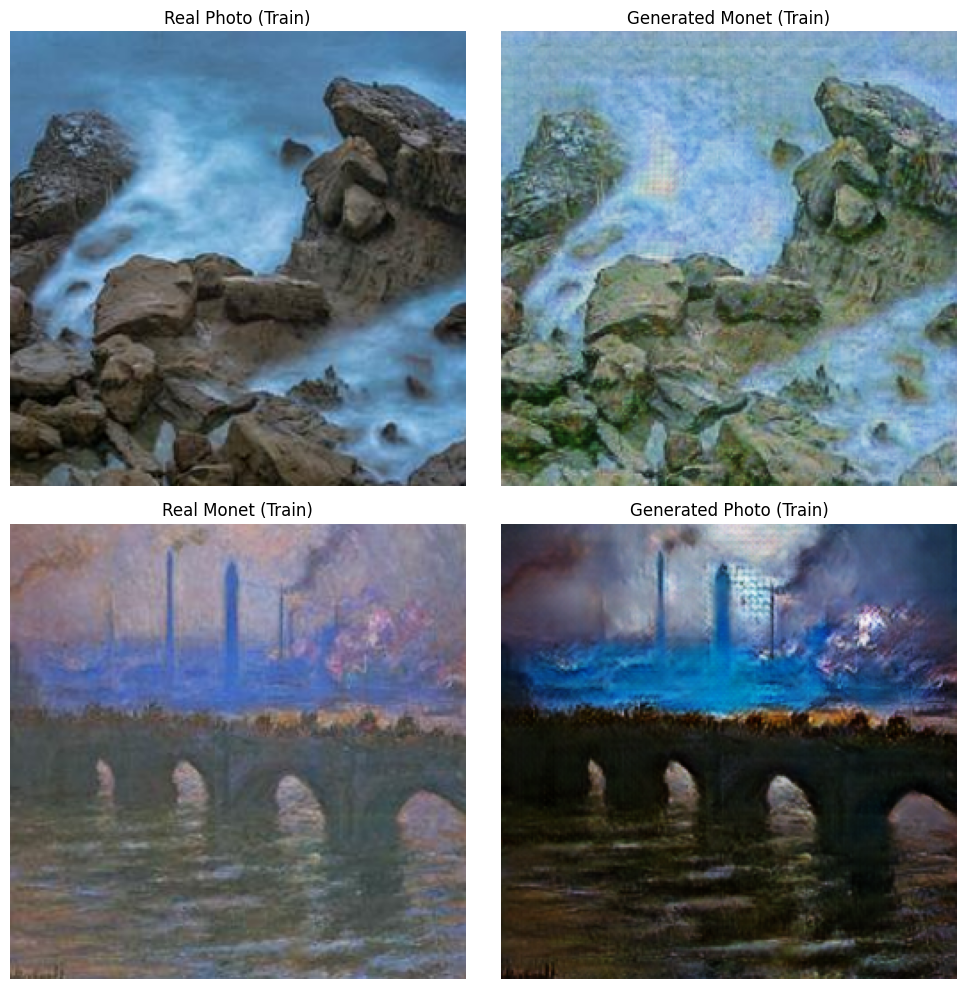

Saved checkpoint for epoch 30 (suffix _2) to /content/drive/MyDrive/MonetGAN_Checkpoints_Exp1


In [12]:

# Fixed samples for visualization
# Validation sample
val_batch = next(iter(val_loader))
fixed_photo_val = val_batch['photo'].to(DEVICE)
fixed_monet_val = val_batch['monet'].to(DEVICE)

# Training sample (New)
train_batch = next(iter(train_loader))
fixed_photo_train = train_batch['photo'].to(DEVICE)
fixed_monet_train = train_batch['monet'].to(DEVICE)

fake_monet_buffer = ReplayBuffer()
fake_photo_buffer = ReplayBuffer()

def show_generated_images(real_p, fake_m, real_m, fake_p, title_suffix=""):
    plt.figure(figsize=(10, 10))
    images = [real_p, fake_m, real_m, fake_p]
    titles = ['Real Photo', 'Generated Monet', 'Real Monet', 'Generated Photo']

    for i, img in enumerate(images):
        plt.subplot(2, 2, i+1)
        plt.imshow(denormalize(img[0]).permute(1, 2, 0).cpu().detach().numpy())
        plt.title(f"{titles[i]} {title_suffix}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print(f"Starting training from epoch {start_epoch} to {N_EPOCHS}...")

for epoch in range(start_epoch, N_EPOCHS):
    start_time = time.time()

    # --- Training ---
    G_Monet.train(); G_Photo.train(); D_Monet.train(); D_Photo.train()

    epoch_loss_G = 0.0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}")):
        real_monet = batch['monet'].to(DEVICE)
        real_photo = batch['photo'].to(DEVICE)

        # Train Generators
        optimizer_G.zero_grad()

        loss_id_A = criterion_identity(G_Monet(real_monet), real_monet)
        loss_id_B = criterion_identity(G_Photo(real_photo), real_photo)
        loss_identity = (loss_id_A + loss_id_B) / 2

        fake_monet = G_Monet(real_photo)
        loss_GAN_AB = criterion_GAN(D_Monet(fake_monet), torch.ones_like(D_Monet(fake_monet)))

        fake_photo = G_Photo(real_monet)
        loss_GAN_BA = criterion_GAN(D_Photo(fake_photo), torch.ones_like(D_Photo(fake_photo)))

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        rec_photo = G_Photo(fake_monet)
        loss_cycle_A = criterion_cycle(rec_photo, real_photo)

        rec_monet = G_Monet(fake_photo)
        loss_cycle_B = criterion_cycle(rec_monet, real_monet)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        loss_G = loss_GAN + (10.0 * loss_cycle) + (5.0 * loss_identity)
        loss_G.backward()
        optimizer_G.step()

        epoch_loss_G += loss_G.item()

        # Train Discriminators
        optimizer_D_Monet.zero_grad()
        loss_real = criterion_GAN(D_Monet(real_monet), torch.ones_like(D_Monet(real_monet)))
        fake_monet_ = fake_monet_buffer.push_and_pop(fake_monet)
        loss_fake = criterion_GAN(D_Monet(fake_monet_.detach()), torch.zeros_like(D_Monet(fake_monet_)))
        loss_D_Monet = (loss_real + loss_fake) / 2
        loss_D_Monet.backward()
        optimizer_D_Monet.step()

        optimizer_D_Photo.zero_grad()
        loss_real = criterion_GAN(D_Photo(real_photo), torch.ones_like(D_Photo(real_photo)))
        fake_photo_ = fake_photo_buffer.push_and_pop(fake_photo)
        loss_fake = criterion_GAN(D_Photo(fake_photo_.detach()), torch.zeros_like(D_Photo(fake_photo_)))
        loss_D_Photo = (loss_real + loss_fake) / 2
        loss_D_Photo.backward()
        optimizer_D_Photo.step()



    lr_scheduler_G.step()
    lr_scheduler_D_Monet.step()
    lr_scheduler_D_Photo.step()

    print(f"Epoch {epoch+1} finished. Avg Generator Loss: {epoch_loss_G / len(train_loader):.4f}")

    # --- Validation / Visualization ---
    if (epoch + 1) % 1 == 0:
        G_Monet.eval()
        G_Photo.eval()
        with torch.no_grad():
            # Validation Sample
            fake_monet_val_vis = G_Monet(fixed_photo_val)
            fake_photo_val_vis = G_Photo(fixed_monet_val)
            show_generated_images(fixed_photo_val, fake_monet_val_vis, fixed_monet_val, fake_photo_val_vis, "(Val)")

            # Training Sample
            fake_monet_train_vis = G_Monet(fixed_photo_train)
            fake_photo_train_vis = G_Photo(fixed_monet_train)
            show_generated_images(fixed_photo_train, fake_monet_train_vis, fixed_monet_train, fake_photo_train_vis, "(Train)")



    # --- Save Checkpoints with _2 suffix ---
    torch.save(G_Monet.state_dict(), os.path.join(CHECKPOINT_DIR, f'G_Monet_epoch_{epoch+1}_2.pth'))
    torch.save(G_Photo.state_dict(), os.path.join(CHECKPOINT_DIR, f'G_Photo_epoch_{epoch+1}_2.pth'))
    torch.save(D_Monet.state_dict(), os.path.join(CHECKPOINT_DIR, f'D_Monet_epoch_{epoch+1}_2.pth'))
    torch.save(D_Photo.state_dict(), os.path.join(CHECKPOINT_DIR, f'D_Photo_epoch_{epoch+1}_2.pth'))
    print(f"Saved checkpoint for epoch {epoch+1} (suffix _2) to {CHECKPOINT_DIR}")


## 5. Testing with Enhanced Logging

Generating test results...


Testing:   0%|          | 0/30 [00:00<?, ?it/s]

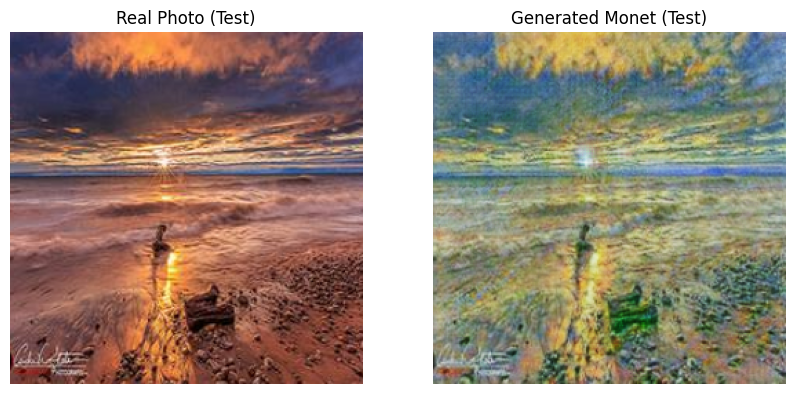

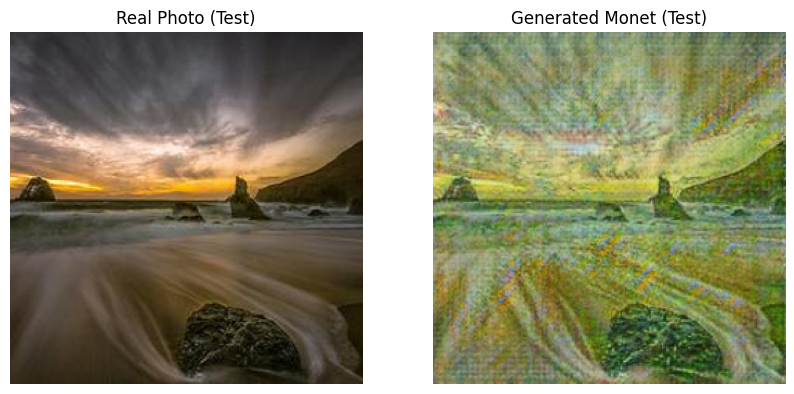

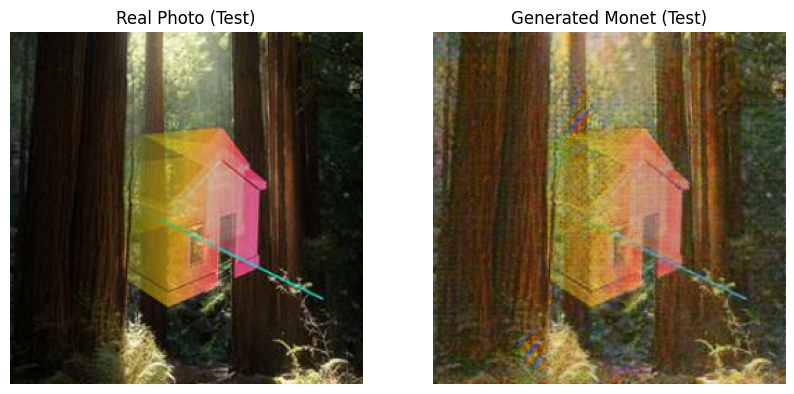

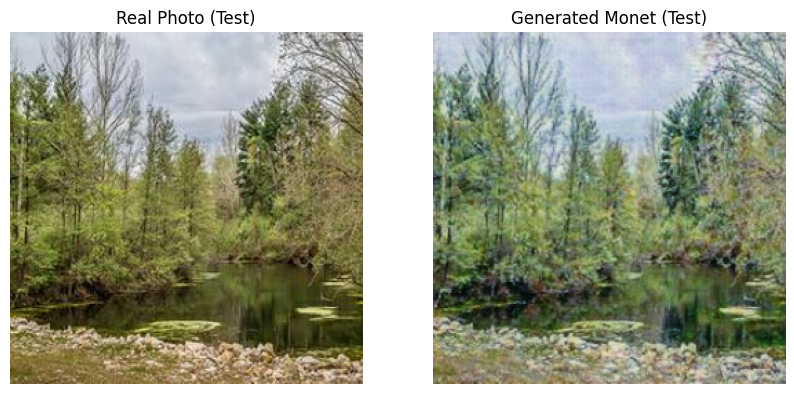

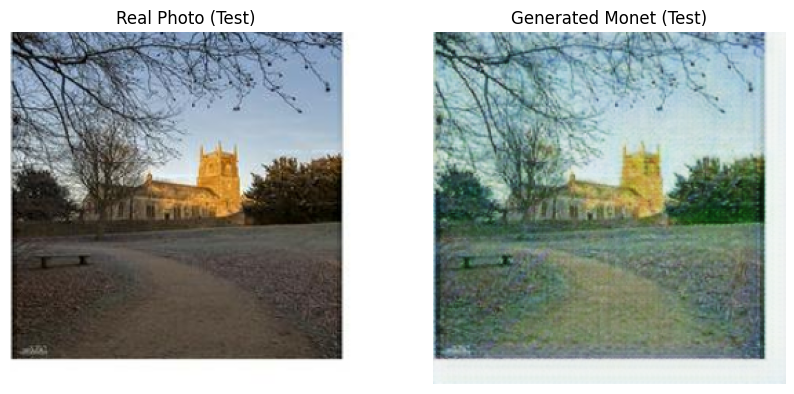

In [13]:

if len(monet_val) == 0:
    print("WARNING: Monet Validation set is empty! Using Monet Train set for validation/test fallback.")
    monet_val = monet_train[:1]

test_dataset = ImageDataset(monet_val, photo_test, transform=transforms_)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size 1 for visualization

G_Monet.eval()

# Generate and Save ALL Test Results to WandB
print("Generating test results...")
test_images_log = []

for i, batch in enumerate(tqdm(test_loader, desc="Testing")):
    real_photo = batch['photo'].to(DEVICE)
    with torch.no_grad():
        fake_monet = G_Monet(real_photo)

    # Visualize first 5 locally
    if i < 5:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(denormalize(real_photo[0]).permute(1, 2, 0).cpu().numpy())
        plt.title("Real Photo (Test)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(denormalize(fake_monet[0]).permute(1, 2, 0).cpu().numpy())
        plt.title("Generated Monet (Test)")
        plt.axis('off')
        plt.show()





In [ ]:

# --- AUTOMATED REPORT GENERATION ---
# This cell uses the WandB Workspaces API to create a report dashboard automatically.

try:
    import wandb_workspaces.reports.v2 as wr

    # Configure Report
    PROJECT = "Monet_GAn"
    ENTITY = "konstantine25b-free-university-of-tbilisi-"

    report = wr.Report(
        project=PROJECT,
        entity=ENTITY,
        title="CycleGAN Experiment 2 Results (with Images)",
        description="Automated report generated from experiment2.ipynb training run."
    )

    # Define Report Structure
    report.blocks = [
        wr.H1("Experiment 2 Overview"),
        wr.P("This report tracks the training progress of Experiment 2 (Full Training)."),
        wr.P(f"Hyperparameters: Epochs={N_EPOCHS}, Batch Size={BATCH_SIZE}, LR={LR}"),

        wr.H2("Training Losses"),
        wr.P("Tracking the Generator and Discriminator losses over time."),
        wr.PanelGrid(
            runsets=[wr.Runset(project=PROJECT, entity=ENTITY)],
            panels=[
                wr.LinePlot(x='Step', y=['Loss/G_Total'], title="Total Generator Loss"),
                wr.LinePlot(x='Step', y=['Loss/G_GAN', 'Loss/G_Cycle', 'Loss/G_Identity'], title="Generator Component Losses"),
                wr.LinePlot(x='Step', y=['Loss/D_Monet', 'Loss/D_Photo'], title="Discriminator Losses")
            ]
        ),

        wr.H2("Validation Results"),
        wr.P("Generated Monet and Photo translations from validation set (Logged every epoch)."),
        wr.PanelGrid(
            runsets=[wr.Runset(project=PROJECT, entity=ENTITY)],
            panels=[
                wr.MediaBrowser(
                    media_keys=["Generated/Val_Photo_to_Monet", "Generated/Val_Monet_to_Photo"],
                    num_columns=2
                )
            ]
        ),

        wr.H2("Test Results"),
        wr.P("Full test set generation (Logged at the end)."),
        wr.PanelGrid(
            runsets=[wr.Runset(project=PROJECT, entity=ENTITY)],
            panels=[
                wr.MediaBrowser(
                    media_keys=["Test/All_Generated_Monet"],
                    num_columns=4
                )
            ]
        )
    ]

    # Save Report
    report.save()
    print(f"✅ WandB Report generated successfully! View it here: {report.url}")

except AttributeError as e:
    print(f"❌ Report generation failed due to API mismatch: {e}")
    print("Try updating wandb: !pip install --upgrade wandb")
except Exception as e:
    print(f"❌ Report generation failed: {e}")
    print("You can still view all results in the main Dashboard link above.")
